In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import logistic
from scipy.special import logit

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
from torch.cuda.amp import autocast, GradScaler

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt


# own utils
from utils.graph import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.continous import *
from utils.sampling_tram_data import *

Train with GPU support.


# 1. Experiments and Paths

In [2]:
experiment_name = "dev_mulitinput_CI_CS"   ## <--- set experiment name
seed=42
np.random.seed(seed)

DATA_PATH = "/home/bule/TramDag/data"
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
os.makedirs(EXPERIMENT_DIR,exist_ok=True)

# 2.  Data

In [3]:


# TODO develop meaningful experiment for interactions



# Fz(z)=Fy(y)
# Fz(h(y|x))=Fy(y)    | z= h(y|x)

# Generate x2

# h(y|x1,x2,x3,x4,x5)= Bernsteinpol(x1,x2) +f2(x2,x3) + f3(x4, x2) + beta * x5        | bernsteinpol is just linearized assumed with a constant factor say 0.42
# h(y|x1,x2,x3,x4,x5)= Bernsteinpol(x1,x2) +f2(x2,x3) + f3(x4, x2) + beta * x5                                          | replace h(y|..) with z
# z                  = 0.42*x2 + beta2 * x1                                           | reformulate to x2
# x2                 = (z-beta2 * x1 )/0.42                                           | sample z from standart logistic via uniform and logit(np.random.uniform(size=n_obs))
# x2                 = (z-beta2 * x1 )/0.42                                           | set beta = 2 (on the edge of the graph)
# x2                 = (z-2 * x1 )/0.42                                               |



### random dgp for testing model pipeline workflow.

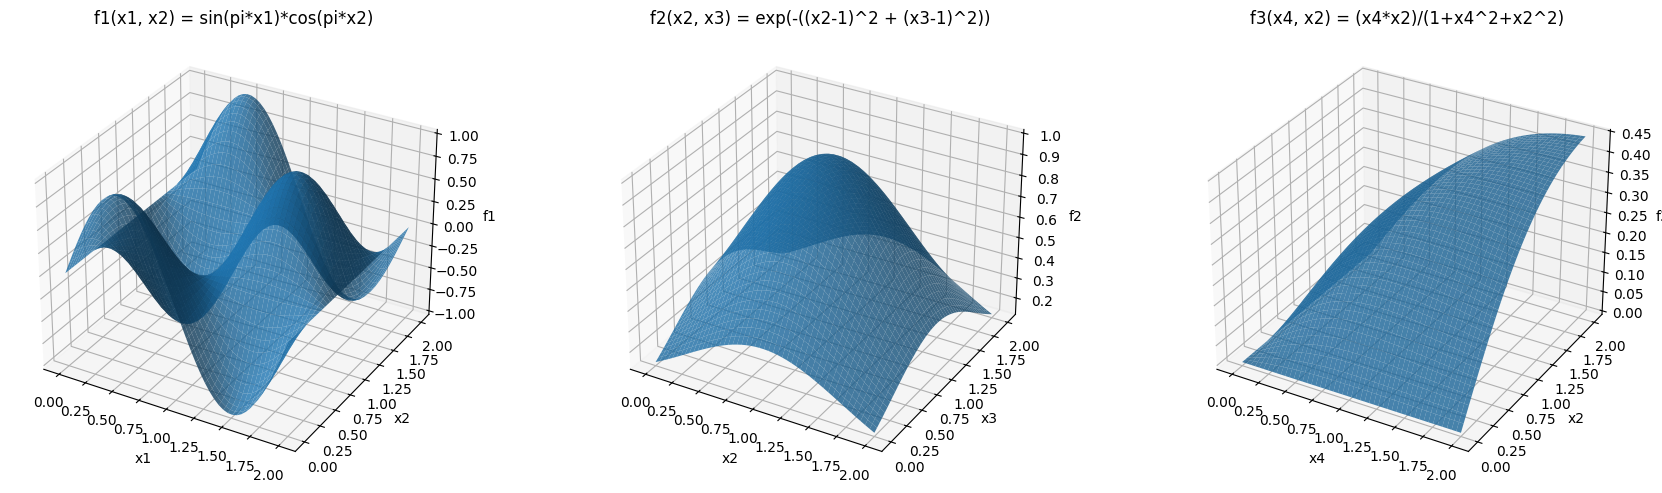

In [4]:
from scipy.special import logit
from mpl_toolkits.mplot3d import Axes3D


# Define the functions used in the DGP
def f1(x1, x2):
    return np.sin(np.pi * x1) * np.cos(np.pi * x2)

def f2(x2, x3):
    return np.exp(-((x2 - 1)**2 + (x3 - 1)**2))

def f3(x4, x2):
    return (x4 * x2) / (1 + x4**2 + x2**2)

def dgp_continuous_interactions(n_obs=10000, seed=42):
    np.random.seed(seed)

    # Independent variables
    x1 = np.random.uniform(0, 2, size=n_obs)
    x2 = np.random.uniform(0, 2, size=n_obs)
    x3 = np.random.uniform(0, 2, size=n_obs)
    x4 = np.random.uniform(0, 2, size=n_obs)
    x5 = np.random.normal(0, 1, size=n_obs)

    # Response variable with interactions
    y = f1(x1, x2) + f2(x2, x3) + f3(x4, x2) + 1.5 * x5

    df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'x5': x5, 'x6': y})
    return df

# Generate data
df = dgp_continuous_interactions()

# Visualize the 3 interaction functions
fig = plt.figure(figsize=(18, 5))

# f1(x1, x2)
ax = fig.add_subplot(131, projection='3d')
x = np.linspace(0, 2, 50)
y = np.linspace(0, 2, 50)
X, Y = np.meshgrid(x, y)
Z = f1(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_title("f1(x1, x2) = sin(pi*x1)*cos(pi*x2)")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("f1")

# f2(x2, x3)
ax = fig.add_subplot(132, projection='3d')
X, Y = np.meshgrid(x, y)
Z = f2(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_title("f2(x2, x3) = exp(-((x2-1)^2 + (x3-1)^2))")
ax.set_xlabel("x2")
ax.set_ylabel("x3")
ax.set_zlabel("f2")

# f3(x4, x2)
ax = fig.add_subplot(133, projection='3d')
X, Y = np.meshgrid(x, y)
Z = f3(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_title("f3(x4, x2) = (x4*x2)/(1+x4^2+x2^2)")
ax.set_xlabel("x4")
ax.set_ylabel("x2")
ax.set_zlabel("f3")

plt.tight_layout()
plt.show()

In [5]:
def dgp(n_obs=10_000, n_vars=6, seed=None):
    """
    Generate a synthetic dataset with n_vars variables and n_obs observations,
    where each variable contains a constant value: x2 = 2, x3 = 3, ..., x{n_vars+1} = n_vars+1.

    Args:
        n_obs (int): Number of observations (rows).
        n_vars (int): Number of variables (columns).
        seed (int or None): Random seed (not used here since data is deterministic).

    Returns:
        pd.DataFrame: Generated dataset.
    """
    values = np.arange(2, 2 + n_vars)  # [2, 3, ..., n_vars + 1]
    data = np.tile(values, (n_obs, 1))  # Repeat each value across n_obs rows
    columns = [f"x{i+1}" for i in range(n_vars)]
    df = pd.DataFrame(data, columns=columns)
    return df

df =dgp(n_obs=10_000, n_vars=6)

In [6]:
df

,x1,x2,x3,x4,x5,x6
0,2,3,4,5,6,7
1,2,3,4,5,6,7
2,2,3,4,5,6,7
3,2,3,4,5,6,7
4,2,3,4,5,6,7
...,...,...,...,...,...,...
9995,2,3,4,5,6,7
9996,2,3,4,5,6,7
9997,2,3,4,5,6,7
9998,2,3,4,5,6,7


In [7]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

# 3. Normalize all sets using training quantiles
def normalize_with_quantiles(df, min_vals, max_vals):
    return (df - min_vals) / (max_vals - min_vals)

# train_df = normalize_with_quantiles(train_df, min_vals, max_vals)
# val_df = normalize_with_quantiles(val_df, min_vals, max_vals)
# test_df = normalize_with_quantiles(test_df, min_vals, max_vals)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")
df.head()

Train size: 8000, Validation size: 1000, Test size: 1000


,x1,x2,x3,x4,x5,x6
0,2,3,4,5,6,7
1,2,3,4,5,6,7
2,2,3,4,5,6,7
3,2,3,4,5,6,7
4,2,3,4,5,6,7


In [8]:
# os.remove(os.path.join(EXPERIMENT_DIR, "adj_matrix.npy"))

Found existing matrix at /home/bule/TramDag/dev_experiment_logs/dev_mulitinput_CI_CS/adj_matrix.npy. plotting...


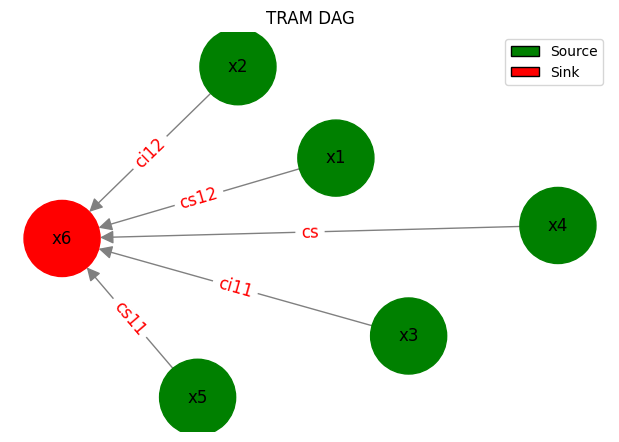

In [9]:
# --- Editable Parameters ---
variable_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
data_type={'x1':'cont','x2':'cont','x3':'cont','x4':'cont','x5':'cont','x6':'cont'}  # continous , images , ordinal

interactive_adj_matrix(variable_names, data_type,experiment_dir=EXPERIMENT_DIR, seed=5)

In [ ]:
x6~ci(x2,x3)+cs(x1,x5)+cs(x4,x5)

In [10]:
adj_matrix = np.load(os.path.join(EXPERIMENT_DIR, "adj_matrix.npy"),allow_pickle=True)

In [11]:
adj_matrix

array([['0', '0', '0', '0', '0', 'cs12'],
       ['0', '0', '0', '0', '0', 'ci12'],
       ['0', '0', '0', '0', '0', 'ci11'],
       ['0', '0', '0', '0', '0', 'cs'],
       ['0', '0', '0', '0', '0', 'cs11'],
       ['0', '0', '0', '0', '0', '0']], dtype=object)

In [ ]:
import numpy as np
import re



In [13]:
adj_matrix

array([['0', '0', '0', '0', '0', 'cs12'],
       ['0', '0', '0', '0', '0', 'ci12'],
       ['0', '0', '0', '0', '0', 'ci11'],
       ['0', '0', '0', '0', '0', 'cs'],
       ['0', '0', '0', '0', '0', 'cs11'],
       ['0', '0', '0', '0', '0', '0']], dtype=object)

In [14]:
data_type

{'x1': 'cont',
 'x2': 'cont',
 'x3': 'cont',
 'x4': 'cont',
 'x5': 'cont',
 'x6': 'cont'}

In [15]:
nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
nn_names_matrix

*************
 Model has Complex intercepts and Complex shifts, please add your Model to the modelzoo 
*************


array([['0', '0', '0', '0', '0', 'ComplexShiftDefaultTabular12'],
       ['0', '0', '0', '0', '0', 'ComplexInterceptDefaultTabular12'],
       ['0', '0', '0', '0', '0', 'ComplexInterceptDefaultTabular11'],
       ['0', '0', '0', '0', '0', 'ComplexShiftDefaultTabular'],
       ['0', '0', '0', '0', '0', 'ComplexShiftDefaultTabular11'],
       ['0', '0', '0', '0', '0', '0']], dtype=object)

In [16]:
conf_dict=get_configuration_dict(adj_matrix,nn_names_matrix, data_type)
# write min max to conf dict
for i,node in enumerate(data_type.keys()):
    conf_dict[node]['min']=min_vals[i].tolist()
    conf_dict[node]['max']=max_vals[i].tolist()
conf_dict

/tmp/ipykernel_1100674/3221631281.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conf_dict[node]['min']=min_vals[i].tolist()
/tmp/ipykernel_1100674/3221631281.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conf_dict[node]['max']=max_vals[i].tolist()


{'x1': {'Modelnr': 0,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 2.0,
  'max': 2.0},
 'x2': {'Modelnr': 1,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 3.0,
  'max': 3.0},
 'x3': {'Modelnr': 2,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 4.0,
  'max': 4.0},
 'x4': {'Modelnr': 3,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 5.0,
  'max': 5.0},
 'x5': {'Modelnr': 4,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_da

ordered paretns check

In [17]:
ordered_parents_datatype, ordered_transformation_terms_in_h, ordered_transformation_term_nn_models_in_h=ordered_parents(node, conf_dict)

In [18]:
ordered_parents_datatype
ordered_transformation_terms_in_h

OrderedDict([('x3', 'ci11'),
             ('x2', 'ci12'),
             ('x4', 'cs'),
             ('x5', 'cs11'),
             ('x1', 'cs12')])

In [19]:
ordered_transformation_term_nn_models_in_h

OrderedDict([('x3', 'ComplexInterceptDefaultTabular11'),
             ('x2', 'ComplexInterceptDefaultTabular12'),
             ('x4', 'ComplexShiftDefaultTabular'),
             ('x5', 'ComplexShiftDefaultTabular11'),
             ('x1', 'ComplexShiftDefaultTabular12')])

In [20]:
train_loader, val_loader = get_dataloader("x6", conf_dict, train_df, val_df, batch_size=10, verbose=True)


In [21]:
next(iter(train_loader))

[[tensor([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]),
  tensor([3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]),
  tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]),
  tensor([6., 6., 6., 6., 6., 6., 6., 6., 6., 6.]),
  tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])],
 tensor([7., 7., 7., 7., 7., 7., 7., 7., 7., 7.])]

## works as expected until here

In [ ]:
from collections import defaultdict

def create_nn_model_names(adj_matrix, data_type):
    """
    Returns the model names for the NN models based on the adj_matrix and data_type.
    Supports extended codes like ci11, cs21 etc.
    """

    # Warn if cs or ci appear anywhere
    if np.any(np.char.startswith(adj_matrix.astype(str), 'cs')) or \
       np.any(np.char.startswith(adj_matrix.astype(str), 'ci')):
        print('*************\n Model has Complex intercepts and Complex shifts, please add your Model to the modelzoo \n*************')

    # Base model name mappings
    full_model_mappings = {
        'cont': {
            'cs': 'ComplexShiftDefaultTabular',
            'ci': 'ComplexInterceptDefaultTabular',
            'ls': 'LinearShift',
            'si': 'SimpleIntercept'
        },
        'ord': {
            'cs': 'ComplexShiftDefaultTabular',
            'ci': 'ComplexInterceptDefaultTabular',
            'ls': 'LinearShift',
            'si': 'SimpleIntercept'
        },
        'other': {
            'cs': 'ComplexShiftDefaultImage',
            'ci': 'ComplexInterceptDefaultImage',
            'ls': 'LinearShift',
            'si': 'SimpleIntercept'
        }
    }

    # Create new matrix to store names
    nn_names_matrix = np.empty_like(adj_matrix, dtype=object)
    var_types = list(data_type.values())

    for i in range(adj_matrix.shape[0]):
        variable_type = var_types[i]
        for j in range(adj_matrix.shape[1]):
            code = str(adj_matrix[i, j])
            if code == '0':
                nn_names_matrix[i, j] = '0'
                continue
            match = re.fullmatch(r'(cs|ci|ls|si)(\d*)', code)
            if match:
                base_code, suffix = match.groups()
                base_name = full_model_mappings[variable_type][base_code]
                nn_names_matrix[i, j] = base_name + suffix
            else:
                nn_names_matrix[i, j] = code  # Leave unrecognized codes unchanged

    return nn_names_matrix

# --------- Extract base model class ---------
def get_base_model_class(class_name: str):
    # Strip digits to get the base class name
    for i, c in enumerate(class_name):
        if c.isdigit():
            return class_name[:i]
    return class_name

# --------- Group features by h_term base ---------
def group_by_base(term_dict, prefix):
    groups = defaultdict(list)
    for feat, conf in term_dict.items():
        h_term = conf['h_term']
        if h_term.startswith(prefix):
            # e.g., cs11 → cs1
            base = h_term[:3] if len(h_term) >= 3 and h_term[2].isdigit() else h_term
            groups[base].append((feat, conf))
    return groups

def get_fully_specified_tram_model(node,conf_dict,verbose=True):  ## old version 11/06/25

    ### iF node is a source -> no deep nn is needed
    if conf_dict[node]['node_type'] == 'source':
        nn_int = SimpleIntercept()
        tram_model = TramModel(nn_int, None)  
        if verbose:
            print('>>>>>>>>>>>>  source node --> only  modelled only  by si') if verbose else None
            print(tram_model)
        return tram_model
    
    else:
        # read terms and model names form the config
        
        _,terms_dict,model_names_dict=ordered_parents(node, conf_dict)
        
        #old
        # terms_dict=conf_dict[node]['transformation_terms_in_h()']
        # model_names_dict=conf_dict[node]['transformation_term_nn_models_in_h()']
        
        # Combine terms and model names and divide in intercept and shift terms
        model_dict=merge_transformation_dicts(terms_dict, model_names_dict)
        intercepts_dict = {k: v for k, v in model_dict.items() if "ci" in v['h_term'] or 'si' in v['h_term']}        
        shifts_dict = {k: v for k, v in model_dict.items() if "ci" not in v['h_term'] and  'si' not in v['h_term']}        
        
        # make sure that nns are correctly defined afterwards
        nn_int, nn_shifts_list = None, []
        # --------- INTERCEPT TERM ---------
        intercept_groups = group_by_base(intercepts_dict, 'ci')

        if not intercept_groups:
            print('>>>>>>>>>>>> No ci detected --> intercept defaults to si') if verbose else None
            nn_int = SimpleIntercept()
        else:
            if len(intercept_groups) > 1:
                raise ValueError("Multiple intercept models detected; only one is currently supported.")

            group = list(intercept_groups.values())[0]
            any_class_name = group[0][1]['class_name']
            base_class_name = get_base_model_class(any_class_name)

            model_cls = globals()[base_class_name]
            n_features = len(group)
            nn_int = model_cls(n_features=n_features)

        # --------- SHIFT TERMS ---------
        shift_groups = group_by_base(shifts_dict, 'cs')

        for group in shift_groups.values():
            any_class_name = group[0][1]['class_name']
            base_class_name = get_base_model_class(any_class_name)

            model_cls = globals()[base_class_name]
            n_features = len(group)
            model = model_cls(n_features=n_features)
            nn_shifts_list.append(model)

        # --------- COMBINE ---------
        tram_model = TramModel(nn_int, nn_shifts_list)
        print('>>> TRAM MODEL:\n',tram_model) if verbose else None
        return tram_model

from collections import defaultdict
import torch

def preprocess_inputs(x, transformation_terms, device='cuda'):
    """
    Prepares model input by grouping features by transformation term base:
      - ci11, ci12 → 'ci1' (intercept)
      - cs11, cs12 → 'cs1' (shift)
      - cs21 → 'cs2' (another shift group)
      - cs, ls → treated as full group keys
    Returns:
      - int_inputs: Tensor of shape (B, n_features) for intercept model
      - shift_list: List of tensors for each shift model, shape (B, group_features)
    """
    assert len(x) == len(transformation_terms), "Mismatch in inputs and term list length"

    grouped_inputs = defaultdict(list)

    for tensor, term in zip(x, transformation_terms):
        # Handle terms like ci11, cs22, ls etc.
        if term.startswith(('ci', 'cs', 'ls')):
            if len(term) > 2 and term[2].isdigit():
                key = term[:3]  # ci11 → ci1, cs22 → cs2
            else:
                key = term      # cs, ls → remain as-is
            grouped_inputs[key].append(tensor)
        else:
            raise ValueError(f"Unknown transformation term: {term}")

    # Separate intercept and shift groups
    int_keys = sorted([k for k in grouped_inputs if k.startswith('ci')])
    shift_keys = sorted([k for k in grouped_inputs if k.startswith(('cs', 'ls'))])

    if len(int_keys) != 1:
        raise ValueError(f"Expected exactly one intercept group, got: {int_keys}")

    # Process intercept inputs
    int_inputs = torch.cat(
        [t.unsqueeze(1).to(device, non_blocking=True) for t in grouped_inputs[int_keys[0]]],
        dim=1
    )  # Shape: (B, n_int_features)

    # Process shift groups
    shift_list = []
    for k in shift_keys:
        shift_tensor = torch.cat(
            [t.unsqueeze(1).to(device, non_blocking=True) for t in grouped_inputs[k]],
            dim=1
        )  # Shape: (B, n_features_for_this_shift_model)
        shift_list.append(shift_tensor)

    return int_inputs, shift_list if shift_list else None


>>> TRAM MODEL:
 TramModel(
  (nn_int): ComplexInterceptDefaultTabular(
    (fc1): Linear(in_features=2, out_features=8, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=8, out_features=8, bias=True)
    (relu2): ReLU()
    (fc3): Linear(in_features=8, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0): ComplexShiftDefaultTabular(
      (fc1): Linear(in_features=1, out_features=32, bias=True)
      (relu1): ReLU()
      (fc2): Linear(in_features=32, out_features=32, bias=True)
      (relu2): ReLU()
      (fc3): Linear(in_features=32, out_features=1, bias=False)
    )
    (1): ComplexShiftDefaultTabular(
      (fc1): Linear(in_features=2, out_features=32, bias=True)
      (relu1): ReLU()
      (fc2): Linear(in_features=32, out_features=32, bias=True)
      (relu2): ReLU()
      (fc3): Linear(in_features=32, out_features=1, bias=False)
    )
  )
)


In [ ]:
tram_model=get_fully_specified_tram_model(node,conf_dict,verbose=True)

In [46]:
x, y = next(iter(train_loader))

int_inputs, shift_inputs = preprocess_inputs(x, ordered_transformation_terms_in_h.values(), device=device)

# Check result shapes
print("Intercept input shape:", int_inputs.shape)
if shift_inputs:
    for i, s in enumerate(shift_inputs):
        print(f"Shift input {i} shape:", s.shape)
else:
    print("No shift inputs detected.")

Intercept input shape: torch.Size([10, 2])
Shift input 0 shape: torch.Size([10, 1])
Shift input 1 shape: torch.Size([10, 2])


In [48]:
# --------- Move model to device ---------
tram_model = tram_model.to(device)

# --------- Forward pass ---------
outputs = tram_model(int_inputs, shift_inputs)

# --------- Print shapes ---------
print("Intercept output:", outputs["int_out"].shape)
if outputs["shift_out"] is not None:
    for i, out in enumerate(outputs["shift_out"]):
        print(f"Shift output {i}:", out.shape)


Intercept output: torch.Size([10, 20])
Shift output 0: torch.Size([10, 1])
Shift output 1: torch.Size([10, 1])


# next steps

- validate in dataloader file that the data is loaded properly
ordered ci11 ci12 

cs11 cs12

cs  

bug in 
  'transformation_term_nn_models_in_h()': {'x1': 'ci11',
   'x2': 'ci12',
   'x3': 'cs11',
   'x4': 'cs12',
   'x5': 'ComplexShiftDefaultTabular'},
  'min': -1.848191891637851,
  'max': 3.451621930052542}}


  this needs to be a model entry for each but in parenthesis is the number like

  ComplexShiftDefaultTabular(11)
  ComplexShiftDefaultTabular(12)

think about implementation of this on paper..




chewck all possible combinatoins


- validate multiinput models for ci and cs

- run forward pass and backprop for these models

- train with proper dgp 


- dataloader delivers tuple (x)

idea: get the grouped data already as tuple and pass the info of multiinput already to the models in get_tram model


it should lsit these models already with the correct input number such that in tram model there is the forward pass correctly.




*************
 Model has Complex intercepts and Complex shifts, please add your Model to the modelzoo 
*************


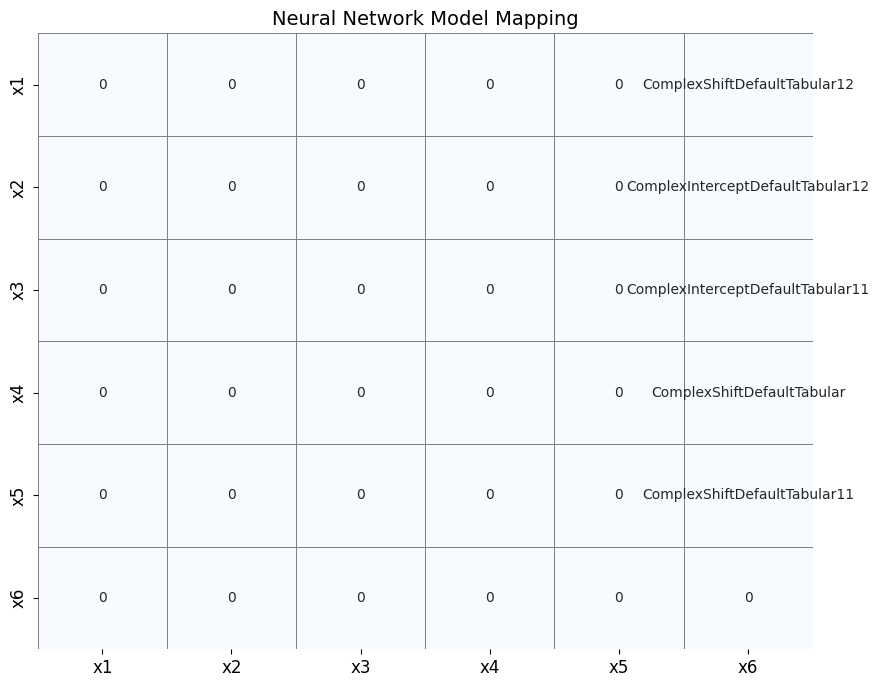

Configuration saved to /home/bule/TramDag/dev_experiment_logs/dev_mulitinput_CI_CS/dev_mulitinput_CI_CS_conf.json


/tmp/ipykernel_1021241/3987547620.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conf_dict[node]['min']=min_vals[i].tolist()   # <---- TODO add quanitle marker
/tmp/ipykernel_1021241/3987547620.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conf_dict[node]['max']=max_vals[i].tolist()


{'x1': {'Modelnr': 0,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 2.0,
  'max': 2.0},
 'x2': {'Modelnr': 1,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 3.0,
  'max': 3.0},
 'x3': {'Modelnr': 2,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 4.0,
  'max': 4.0},
 'x4': {'Modelnr': 3,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 5.0,
  'max': 5.0},
 'x5': {'Modelnr': 4,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_da

In [50]:
adj_matrix = np.load(os.path.join(EXPERIMENT_DIR, "adj_matrix.npy"),allow_pickle=True)
# check if there are Ci or Compelx shifts in the models. If yes define the modelnames
nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
# nn_names_matrix[1,2]='ComplexShiftCustomTabular'
plot_nn_names_matrix(nn_names_matrix,data_type)


#TODO : OPTION write config to a argparser to  and args object to pass datatypes

conf_dict=get_configuration_dict(adj_matrix,nn_names_matrix, data_type)
# write min max to conf dict
for i,node in enumerate(data_type.keys()):
    conf_dict[node]['min']=min_vals[i].tolist()   # <---- TODO add quanitle marker
    conf_dict[node]['max']=max_vals[i].tolist()
    

# write to file
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"{experiment_name}_conf.json")
with open(CONF_DICT_PATH, 'w') as f:
    json.dump(conf_dict, f, indent=4)
    
print(f"Configuration saved to {CONF_DICT_PATH}")

conf_dict